In [1]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

#######딥러닝 라이브러리##########
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN

tf.keras.backend.set_floatx('float64')

2023-10-31 07:08:48.739779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 07:08:48.739841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 07:08:48.739866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 07:08:48.747004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 07:08:49.544240: W tensorflow/compiler/

In [2]:
# 맵플롯립 시각화 및 한국어 설정 (맷플롯립 시각화 시)
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록(그래프가 화면에 뜨지 않을 때)
%matplotlib inline

# 그래프(figure)에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정(나눔고딕체)
plt.rc('font', family='NanumGothic')

# 조용하 강사님이 올려주신 코드(한글화-matplotlib)
!pip install koreanize-matplotlib
import koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
train=pd.read_csv('train.csv', encoding = 'cp949')
test=pd.read_csv('test.csv', encoding = 'cp949')
submission=pd.read_csv('sample_submission.csv', encoding = 'cp949')

In [4]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [5]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 컬럼명 변환을 위한 리스트 할당
train_col = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'rain', 'sun', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'hum', 'rain', 'sun', 'cooler', 'solar']
train.columns=train_col
test.columns=test_col

In [7]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    # train['week']=train.date_time.dt.weekofyear
    
    ## cyclical encoding
    train['sin_time'] = np.sin(2*np.pi*train.hour/24)
    train['cos_time'] = np.cos(2*np.pi*train.hour/24)
    
    ### 공휴일 변수 추가
    train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
    train.loc[('2020-08-17'<=train.date_time)&(train.date_time<'2020-08-18'), 'holiday'] = 1
    
    
    ### 날씨 변수 추가
    train['THI'] = 1.9*train['temp'] - 0.55*(1-train['hum'])*(1.8*train['temp']-26)+32                                # 불쾌지수
    train['chill']=13.12+0.6215*train['temp']-11.37*train['wind']**0.16+0.3965*train['wind']**0.16*train['temp']        # 체감온도
    
    train['냉방도시'] = 0  # 냉방이 필요하지 않은 도시로 초기화

    # 여름 동안 냉방이 필요한 도시로 설정
    train.loc[(train['temp'] > 30) & (train['hum'] > 70), '냉방도시'] = 1
    
    return train

In [8]:
def make_nan(test):
    
    # 결측치 처리
    test['wind']=test['wind'].interpolate(method='linear')
    test['rain']=test['rain'].interpolate(method='linear')
    test['sun']=test['sun'].interpolate(method='linear')
    
    test['temp']=test['temp'].interpolate(method='polynomial',order=3).fillna(method='ffill')
    test['hum']=test['hum'].interpolate(method='polynomial',order=3).fillna(method='ffill')
    
    test['cooler']=test['cooler'].fillna(0)
    test['solar']=test['solar'].fillna(0)
    
    return test

In [9]:
train = make_time(train)
#train = make_power(train)
test = make_nan(test)
test = make_time(test)

In [10]:
def make_weather(data):
    weather=data.groupby(['num','dayofyear'])['temp'].agg({'max','min','mean'}).reset_index()
    weather['temp_range']=weather['max']-weather['min']
    
    data=pd.merge(data,weather,on=['num','dayofyear'],how='left')
    return data

In [11]:
#train = make_power(train)
train = make_weather(train)
test=make_weather(test)

In [12]:
train.columns

Index(['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'rain', 'sun',
       'cooler', 'solar', 'month', 'day', 'hour', 'weekday', 'dayofyear',
       'sin_time', 'cos_time', 'holiday', 'THI', 'chill', '냉방도시', 'max',
       'mean', 'min', 'temp_range'],
      dtype='object')

In [13]:
from sklearn.preprocessing import MinMaxScaler

# 입력 변수 선택
feature_cols = ['temp', 'wind', 'hum', 'rain', 'sun', 'cooler', 'holiday', 'THI', 'chill', '냉방도시', 'mean', 'min', 'max', 'temp_range']
## 종속변수 선택
label_cols = ['power']


In [14]:
# from sklearn.preprocessing import MinMaxScaler

# # 입력 변수 선택
# feature_cols = ['temp', 'wind', 'hum', 'rain', 'sun', 'cooler', 'holiday', 'THI', 'chill', '냉방도시', 'mean', 'min', 'max', 'temp_range']
# ## 종속변수 선택
# label_cols = ['power']

# # MinMaxScaler를 생성하고 모든 테스트 데이터에 적용
# scaler = MinMaxScaler()

# # 데이터 전처리 (MinMaxScaler를 일부 열에만 적용)
# train[feature_cols[:]] = scaler.fit_transform(train[feature_cols[:]])

# # 데이터 전처리 (MinMaxScaler를 일부 열에만 적용)
# test[feature_cols[:]] = scaler.fit_transform(test[feature_cols[:]])

In [15]:
feature_df = pd.DataFrame(train[feature_cols], columns=feature_cols)
label_df = pd.DataFrame(train[label_cols], columns=label_cols)

In [17]:
## 딥러닝 학습을 위해 numpy array로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

In [18]:
# ## make_sequence 함수 정의
def make_sequence(feature, label, window_size=168):
    feature_list, label_list = [], []

    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [19]:
# ## 각 건물은 2040씩 차이가 있으므로, 60개 건물마다 2040씩 분리
train_feature = []
train_label = []

for i in range(60):
    feature = feature_np[i*2040:(i+1)*2040]
    label = label_np[i*2040:(i+1)*2040]

    feature, label = make_sequence(feature, label, 168)

    train_feature.append(feature)
    train_label.append(label)

In [20]:
feature_df = pd.DataFrame(test[feature_cols], columns=feature_cols)

In [21]:
## 딥러닝 학습을 위해 numpy array로 변환
feature_np = feature_df.to_numpy()

In [22]:
# ## 각 건물은 2040씩 차이가 있으므로, 60개 건물마다 2040씩 분리
test_feature = []
test_label = []

for i in range(60):
    feature = feature_np[i*168:(i+1)*168]
    label = label_np[i*168:(i+1)*168]

    feature, label = make_sequence(feature, label, 168)

    test_feature.append(feature)
    test_label.append(label)

In [28]:
test_feature

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time

list = []
   
# 체크포인트 콜백
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath = './best_model.h5', monitor = 'loss', save_best_only=True)
    
# 조기종료 콜백, restore True는 만약 8번이 최적이라 10번까지했을 때 8번 값을 뽑기위해 작성
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 2, restore_best_weights=True)

for i in range(0,1) :
    # 코드 실행 시작 시간 기록
    start_time = time.time()
    X = train_feature[i]
    Y = train_label[i]
    x = test_feature[i]
    
    x_train = X
    y_train = Y
    x_test = x

    ## LSTM 모델 생성
    model = tf.keras.Sequential()
    
    model.add(LSTM(units=128, activation='relu', input_shape=x_train[0].shape, return_sequences=True))  # LSTM 레이어 추가
    model.add(LSTM(units=64, activation='relu'))  # 두 번째 LSTM 레이어 추가
    model.add(Dense(1))
    
    model.summary()
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    history = model.fit(x_train, y_train,
                  epochs=10, batch_size=8, callbacks=[checkpoint_cb, early_stopping_cb])
    
    pred = model.predict(x_test) ## x_test를 넣어서 예측하기

    list.append(pred)
    
    # 시간대 생성 (예: 0부터 데이터 포인트 수까지)
    time1 = np.arange(len(y_train))
    time2 = np.arange(len(y_train),len(y_train)+len(pred))
    
    # 실제 레이블과 예측값의 시각화를 위한 그래프
    plt.figure(figsize=(18, 6))
    plt.plot(time1, y_train, label="실제 레이블", color='blue')
    plt.plot(time2, pred, label="예측 레이블", color='red')
    
    plt.xlabel("시간")
    plt.ylabel("전력 사용량")
    plt.legend()
    plt.show()
    # 코드 실행 종료 시간 기록
    end_time = time.time()
    # 실행 시간 계산 (종료 시간 - 시작 시간)
    execution_time = end_time - start_time
    print(f"코드 실행 시간: {execution_time} 초")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          73216     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 122689 (958.51 KB)
Trainable params: 122689 (958.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
234/234 [==============================] - 26s 106ms/step - loss: 677777824744754.8750 - mae: 2828683.8650
Epoch 2/10
  1/234 [..............................] - ETA: 24s - loss: 3181004369676.4194 - mae: 826523.5256

/home/jupyter-user01/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


234/234 [==============================] - 25s 106ms/step - loss: 825575946724951946428416.0000 - mae: 44877646612.6195
Epoch 3/10
234/234 [==============================] - 25s 106ms/step - loss: 9687206729545540234641408.0000 - mae: 495484993020.7392


ValueError: Expected input data to be non-empty.

In [27]:
test_feature

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 

In [37]:
submission=pd.read_csv('sample_submission.csv')

In [40]:
submission['answer']=pd.DataFrame(np.array(list).flatten())

In [42]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8573.583105
1,1 2020-08-25 01,8551.164956
2,1 2020-08-25 02,8553.746838
3,1 2020-08-25 03,8588.466516
4,1 2020-08-25 04,8598.017208
...,...,...
10075,60 2020-08-31 19,NaN
10076,60 2020-08-31 20,NaN
10077,60 2020-08-31 21,NaN
10078,60 2020-08-31 22,NaN


In [41]:
submission.to_csv('submission_lstm.csv',index=False)

In [55]:
pred

array([[ 502.02790165],
       [ 454.57552028],
       [ 466.87538296],
       [ 496.75816688],
       [ 498.86785873],
       [ 564.6881822 ],
       [ 677.15303664],
       [ 807.96022796],
       [ 961.9815555 ],
       [1051.40239439],
       [ 957.05980189],
       [1012.17896457],
       [1083.81664663],
       [ 938.77460758],
       [1002.41573899],
       [1091.04911507],
       [ 957.72169975],
       [1019.8129253 ],
       [1049.94473987],
       [ 838.03255924],
       [ 802.32263642],
       [ 718.36514438],
       [ 570.91249879],
       [ 540.42228488],
       [ 540.36809939],
       [ 445.7487797 ],
       [ 478.11277381],
       [ 499.17638554],
       [ 427.40306224],
       [ 474.28459534],
       [ 524.63413031],
       [ 496.12490556],
       [ 589.75082266],
       [ 704.6063209 ],
       [ 724.75218523],
       [ 859.87056635],
       [ 968.90561047],
       [ 688.66727795],
       [ 719.0125091 ],
       [ 778.07990639],
       [ 574.38233885],
       [ 606.652

In [56]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mae
0,392424.677786,461.686857
1,91408.202467,243.547233
2,85752.014654,231.307201
3,77932.735153,223.723725
4,76702.693996,219.435229
5,78983.098613,221.259364
6,75974.694891,218.479810
7,75151.605400,216.672696
8,75554.928092,219.136006
9,71464.673837,211.868175


In [57]:
# 인덱스가 0부터 시작이므로 -2 + 1해서 15번
print(early_stopping_cb.stopped_epoch)

0


In [58]:
# 이렇게 평가해야 함
model = keras.models.load_model('best_model.h5')

In [59]:
pred = model.predict(x_test) ## x_test를 넣어서 예측하기

5/5 [==============================] - 0s 11ms/step


In [60]:
pred

array([[ 536.31278295],
       [ 477.17935676],
       [ 495.05926991],
       [ 532.21129978],
       [ 521.03574265],
       [ 587.08253405],
       [ 688.89346582],
       [ 780.16683383],
       [ 913.08847187],
       [ 985.96608608],
       [ 922.9540405 ],
       [ 986.51010119],
       [1050.16887656],
       [ 939.92711364],
       [1006.21618861],
       [1082.36765282],
       [ 947.4649726 ],
       [ 967.99298602],
       [ 978.00364758],
       [ 817.50299332],
       [ 796.74475841],
       [ 731.50518819],
       [ 581.91658208],
       [ 559.50499194],
       [ 569.46052182],
       [ 469.15862816],
       [ 504.86796164],
       [ 540.39287761],
       [ 463.42313517],
       [ 512.57944169],
       [ 573.5084044 ],
       [ 537.50982484],
       [ 633.91124334],
       [ 745.79710529],
       [ 738.35595623],
       [ 858.01003443],
       [ 949.63784684],
       [ 743.48400377],
       [ 765.99477061],
       [ 808.88080129],
       [ 608.51105914],
       [ 645.866

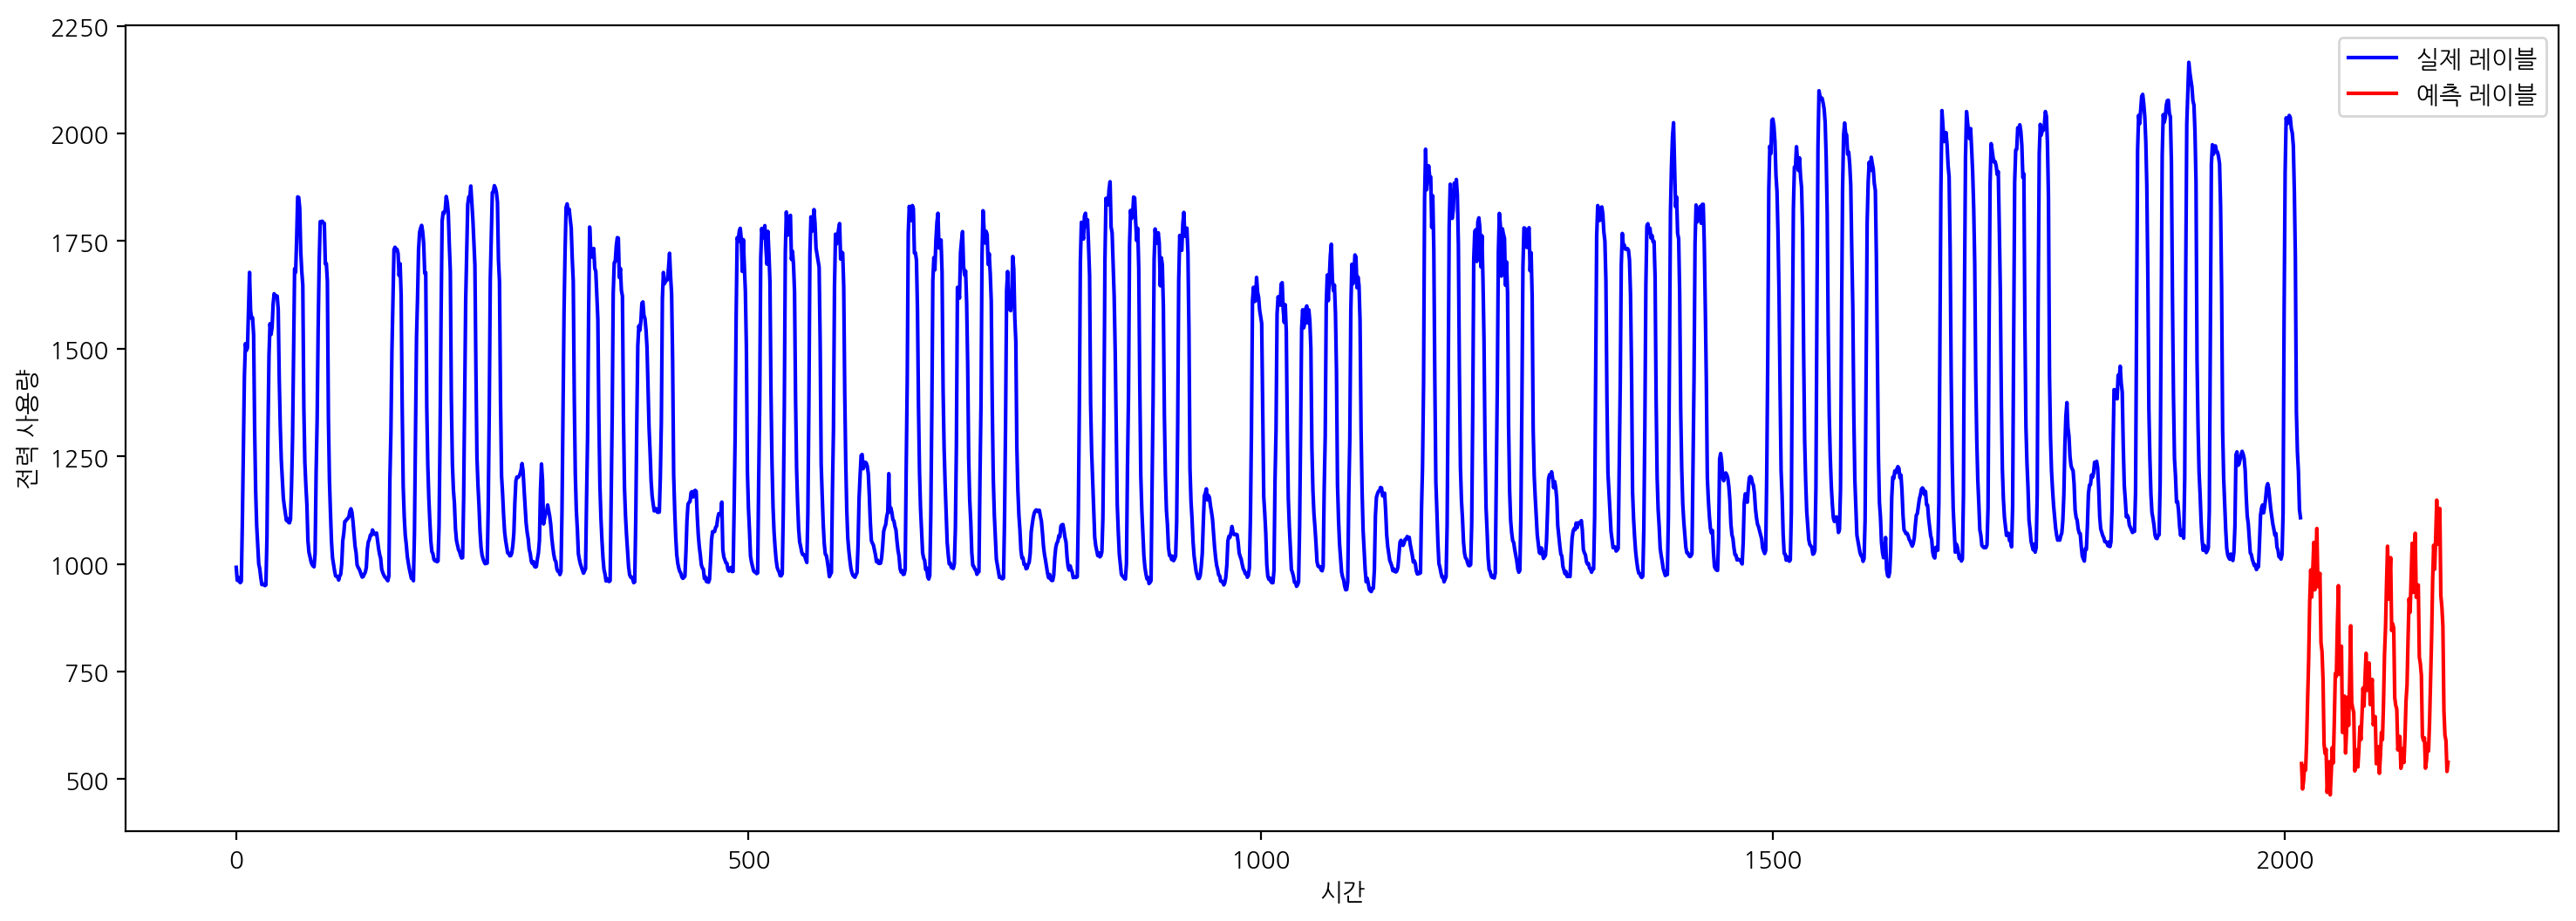

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# 시간대 생성 (예: 0부터 데이터 포인트 수까지)
time1 = np.arange(len(y_train))
time2 = np.arange(len(y_train),len(y_train)+len(pred))
# 실제 레이블과 예측값의 시각화를 위한 그래프
plt.figure(figsize=(18, 6))
plt.plot(time1, y_train, label="실제 레이블", color='blue')
plt.plot(time2, pred, label="예측 레이블", color='red')

plt.xlabel("시간")
plt.ylabel("전력 사용량")
plt.legend()
plt.show()